# 导入数据到AWS Neptune
数据导入的方式主要有四种：
+ 通过SDK导入,目前支持Java,Python,.Net,Node.js
+ 通过Https REST API与数据库进行交互
+ 通过DMS服务导入数据
+ 通过Neptune Loader批量导入数据，支持csv(Gremlin), ntriples, nquads, rdfxml, turtle (RDF)格式

本文介绍如何通过SDK与AWS Neptune进行交互并导入测试数据

# 安装必要包
通过Python连接到 Amazon Neptune 数据库实例并执行 Gremlin遍历需要安装gremlinpython包, 请确保正确安装，如采用的workshop提供的docker image则默认已安装。
```
pip install gremlinpython ‑‑user
```
导入必要包

In [12]:
from gremlin_python import statics
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.traversal import T
from gremlin_python.process.traversal import Order
from gremlin_python.process.traversal import Cardinality
from gremlin_python.process.traversal import Column
from gremlin_python.process.traversal import Direction
from gremlin_python.process.traversal import Operator
from gremlin_python.process.traversal import P
from gremlin_python.process.traversal import Pop
from gremlin_python.process.traversal import Scope
from gremlin_python.process.traversal import Barrier
from gremlin_python.process.traversal import Bindings
from gremlin_python.process.traversal import WithOptions
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
import pandas as pd
import os

# HPO与CHPO数据库介绍
+ Human Phenotype Ontology, HPO - 人类表型术语集<br/>
旨在提供人类疾病中用于描述表型异常的标准词汇. HPO每个术语描述了一种表型异常，如房间隔缺损(atrial septal defect), HPO目前正在利用从医学文献, [Orphanet](http://www.orphanet.org/), [DECIPHER](https://decipher.sanger.ac.uk/)和[OMIM](http://www.omim.org/)数据库获得的信息进行开发, 目前包含约11,000项名词和超过115000项关于遗传性疾病的注释. HPO数据库还提供了一套针对约4000种疾病的注释(annotations).
+ Chinese Human Phenotype Ontology, CHPO - 中文人类表型术语集<br/>
中文版的HPO有助于中国临床医生以标准化的医学名词和术语来描述罕见病患者的表型, 这样不仅有助于诊断疾病, 确定致病基因, 还能帮助研究人员寻找疾病与特定表型之间的关系。 

CHPO中存储了表型定义、中英文名称、分类定义等关键信息，我们将表型作为主体，构建表型分类网络:<br/>
**<font color=#FF0000> 所属术语 ——> 主分类 ——> 表型  </font>**

In [613]:
# 查看分类及其所属术语
pd.read_csv("Data/CHPO/chpo.classification.txt", sep='\t', header=0)

,所属术语,主分类(英),主分类(译名)
0,表型异常,Abnormality of connective tissue,结缔组织异常
1,表型异常,Abnormality of the voice,声音异常
2,表型异常,Abnormality of the nervous system,神经系统异常
3,表型异常,Abnormality of the breast,乳房异常
4,表型异常,Abnormality of the eye,眼部异常
5,表型异常,Abnormality of prenatal development or birth,胎儿产前发育或出生异常
6,表型异常,Neoplasm,肿瘤
7,表型异常,Abnormality of the endocrine system,内分泌系统异常
8,表型异常,Abnormality of head and neck,头部和颈部的异常
9,表型异常,Abnormality of the immune system,免疫系统异常


In [614]:
# 查看表型及其分类
pd.read_csv("Data/CHPO/chpo.2016-10.txt", sep='\t', header=0)

,主分类(中文),HPO编号,名称(英文),名称(中文),定义(英文),定义(中文)
0,生长异常,HP:0000002,Abnormality of body height,身高异常,Deviation from the norm of height with respect...,身高偏离该年龄性别预期身高的正常范围。
1,泌尿生殖系统的异常,HP:0000003,Multicystic kidney dysplasia,多囊性肾发育不全,Multicystic dysplasia of the kidney is charact...,多囊性肾发育不全的特点是各种大小不一的肾囊肿，缺乏正常肾盂肾盏系统。这种状态伴发输尿管或肾盂...
2,遗传模式,HP:0000005,Mode of inheritance,遗传模式,The pattern in which a particular genetic trai...,NaN
3,遗传模式,HP:0000006,Autosomal dominant inheritance,常染色体显性遗传,A mode of inheritance that is observed for tra...,NaN
4,遗传模式,HP:0000007,Autosomal recessive inheritance,常染色体隐形遗传,A mode of inheritance that is observed for tra...,NaN
...,...,...,...,...,...,...
11891,神经系统的异常;头或颈部的异常,HP:3000075,Abnormality of lingual nerve,舌神经异常,An abnormality of a lingual nerve.,NaN
11892,头或颈部的异常;免疫系统的异常,HP:3000076,Abnormality of lingual tonsil,舌扁桃体异常,An abnormality of a lingual tonsil.,NaN
11893,头或颈部的异常;骨骼系统的异常,HP:3000077,Abnormality of mandible condylar process,下颌骨髁突异常,An abnormality of a mandible condylar process.,NaN
11894,头或颈部的异常;骨骼系统的异常,HP:3000078,Abnormality of mandible coronoid process,下颌骨喙突异常,An abnormality of a mandible coronoid process.,NaN


# 定义CHPO数据逻辑类

In [423]:
class CHPO:
    __transform = {
        "所属术语":"term",
        "主分类(英)":"category_en",
        "主分类(译名)":"category_cn",
        "主分类(中文)":"category_cn",
        "HPO编号":"hpo_id",
        "名称(英文)":"name_en",
        "名称(中文)":"name_cn",
        "定义(英文)":"definition_en",
        "定义(中文)":"definition_cn"
    }
    __chpo = list()
    __chpo_category = list()
    __term_category = dict()

    def __init__(self,chpo="",classification=""):
        self.load(type="chpo",filepath=chpo)
        self.load(type="classification",filepath=classification)


    def load(self,type="chpo",filepath="chpo.txt"):
        input_file = open(filepath)
        header = input_file.readline().strip().split("\t")
        if type=="chpo":
            """
            [
               {
                   'category_cn': '泌尿生殖系统的异常', 
                    'hpo_id': 'HP:0000079', 
                    'name_en': 'Abnormality of the urinary system', 
                    'name_cn': '泌尿系统异常', 
                    'definition_en': 'An abnormality of the `urinary system` (FMA:7159).', 
                    'definition_cn': '泌尿系统的异常。'
                }
            ]
            """
            for line in input_file:
                items = line.split("\t")
                item = dict()
                for i in range(len(items)):
                    item[self.__transform[header[i]]] = items[i].strip() if items[i]!="\n" else ""
                self.__chpo.append(item)
        elif type=="classification":
            """
            [
                {'term': '表型异常', 'category_en': 'Abnormality of connective tissue','category_cn': '结缔组织异常'}, 
                {'term': '表型异常', 'category_en': 'Abnormality of the voice', 'category_cn': '声音异常'}
            ]
            """
            for line in input_file:
                items = line.split("\t")
                item = dict()
                for i in range(len(items)):
                    item[self.__transform[header[i]]] = items[i].strip() if items[i]!="\n" else ""
                self.__chpo_category.append(item)

    def insert_term(self,graph):
        existslist = dict()
        for i in self.__chpo_category:
            if i["term"] and i["term"] not in existslist:
                try:
                    graph.addV('Term').property(T.id, i["term"]).next()
                    existslist[i["term"]] = 1
                except Exception as e:
                        pass
            self.__term_category[i["category_cn"]] = i["term"]
            
    def insert_phenotypic_category(self,graph,l_limit=100):
        l_count = 0
        phenotypic_existslist = dict()
        for i in self.__chpo:
            category = i["category_cn"].strip().split(";")
            for c in category:
                if c and c not in phenotypic_existslist.keys():
                    try:
                        graph.addV('PhenotypicCategory').property(T.id, c).next()
                        phenotypic_existslist[c] = 1
                        if c in self.__term_category.keys():
                            graph.V(c).hasLabel('PhenotypicCategory').addE('CategoryBelong').to(graph.V(self.__term_category[c]).hasLabel('Term')).next()
                        l_count += 1
                        if l_count == l_limit:break;
                    except Exception as e:
                        pass
            



    def insert_phenotypic_with_relation(self,graph,l_limit=1000):
        l_count = 0
        for i in self.__chpo:
            try:
                graph.addV('Phenotypic').property(T.id, i["hpo_id"]).property('name_en',i["name_en"]).property('name_cn',i["name_cn"]).property('definition_en',i["definition_en"]).property('definition_cn',i["definition_cn"]).next()
            except Exception as e:
                pass
                
            if i["category_cn"]:
                category = i["category_cn"].split(";")
                for c in category:
                    try:
                        graph.V(i["hpo_id"]).hasLabel('Phenotypic').addE('PhenotypicBelong').to(graph.V(c).hasLabel('PhenotypicCategory')).next()
                    except Exception as e:
                        pass
            l_count += 1
            if l_count == l_limit:break;
                    
# 创建数据库连接，初始化类对象
graph = Graph()
remoteConn = DriverRemoteConnection('wss://{}:8182/gremlin'.format(os.environ.get('GRAPH_NOTEBOOK_HOST')),'g')
g = graph.traversal().withRemote(remoteConn)

Phenotypic = CHPO(chpo="Data/CHPO/chpo.2016-10.txt",classification="Data/CHPO/chpo.classification.txt")



## 导入所属术语及疾病分类

In [424]:
# 导入所属术语
%time Phenotypic.insert_term(g)

CPU times: user 13.9 ms, sys: 220 µs, total: 14.1 ms
Wall time: 83.2 ms


In [ ]:
# 导入主分类
%time Phenotypic.insert_phenotypic_category(g,l_limit=100)

### 查询表型分类示例
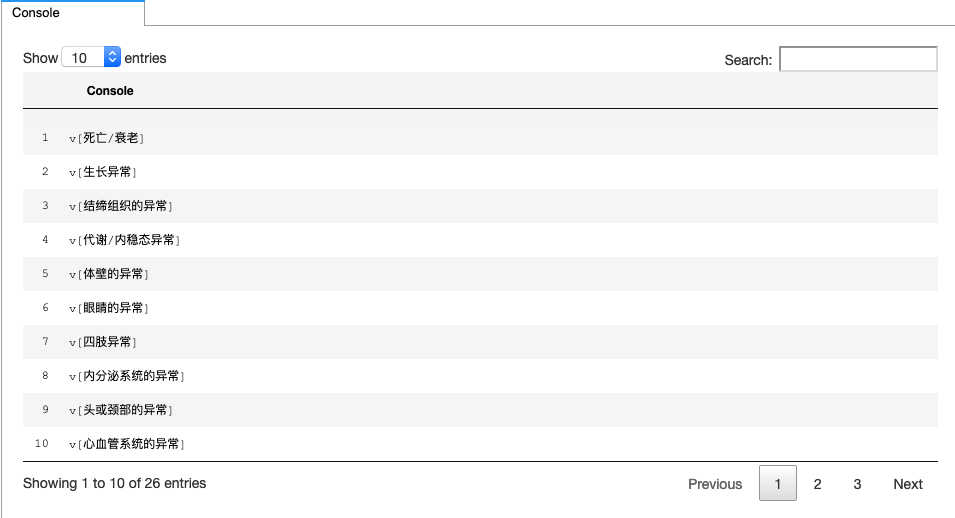

In [2]:
%%gremlin
g.V().hasLabel('PhenotypicCategory')


## 导入表型及分类关系
约3min

In [440]:
%time Phenotypic.insert_phenotypic_with_relation(g,l_limit=100000)

CPU times: user 24.7 s, sys: 3.94 s, total: 28.6 s
Wall time: 2min 51s


### 查询“表型异常”分类下表型
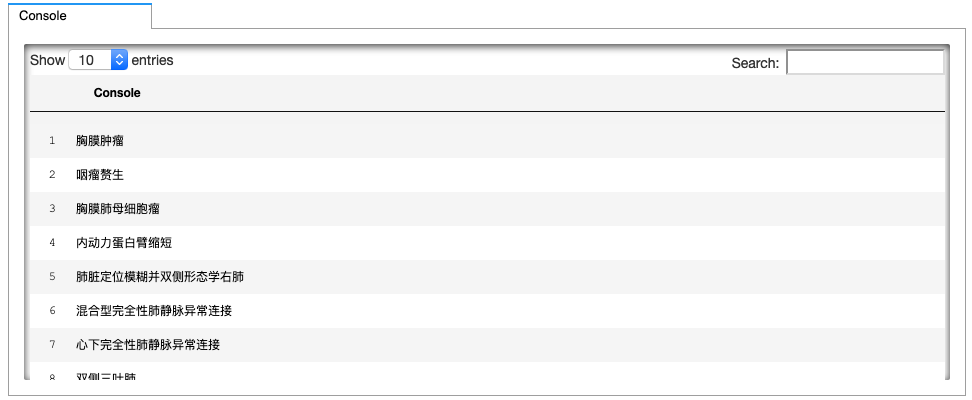

In [3]:
%%gremlin
g.V("表型异常").hasLabel('Term').in().in().values('name_cn').limit(200)

In [4]:
%%gremlin
g.V().count()
// 查询数据库点数量

# OMIM数据库介绍
* OMIM 为“0nline Mendelian Inheritance in Man”的简称，即在线《人类孟德尔遗传》，是一个关于人类基因和遗传紊乱的数据库（持续更新）。主要着眼于遗传性的基因疾病，包括文本信息和相关参考信息、序列纪录、图谱和相关其他数据库。
* MIM 包括所有已知的遗传病、遗传决定的性状及其基因，除了简略描述各种疾病的临床特征、诊断、鉴别诊断、治疗与预防外，还提供已知有关致病基因的连锁关系、染色体定位、组成结构和功能、动物模型等资料，并附有经缜密筛选的相关参考文献。MIM制定的各种遗传病、性状、基因的编号，简称MIM 号，为全世界所公认。有关疾病的报道必须冠以MIM号，以明确所讨论的是哪一种遗传病。可见MIM 在国际医学界的权威性.
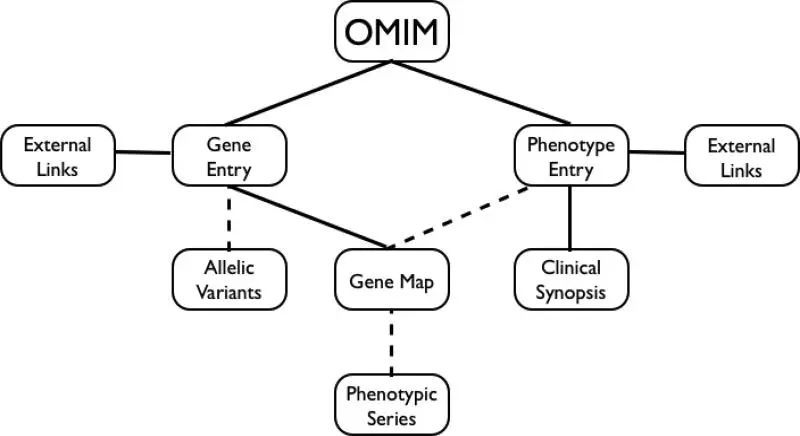



在OMIM数据库中，不同id代表的含义也有区别，由于我们需要构建OMIM与CHPO/HPO之间的关联，而CHPO/HPO中遗传模式的分类中已存在这部分关系，此处不再单独建立实体对应关系
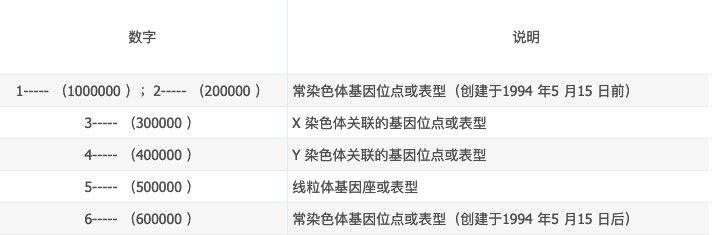


In [664]:
# OMIM数据库内容
pd.read_csv("Data/OMIM/OMIM_Disease.txt", sep='\t', header=0)

,OMIM编码,英文名,中文译名
0,OMIM:604213,CHUDLEY-MCCULLOUGH SYNDROME; CMCS,Chudley-mccullough综合征；CMCS
1,OMIM:301040,"ALPHA-THALASSEMIA/MENTAL RETARDATION SYNDROME,...",X-连锁α-地中海贫血/智力迟钝综合征；ATRX
2,OMIM:309580,"MENTAL RETARDATION-HYPOTONIC FACIES SYNDROME, ...",X染色体相关的精神发育迟滞-肌张力减退综合征1型（MRXHF1）
3,OMIM:300448,ALPHA-THALASSEMIA MYELODYSPLASIA SYNDROME; ATMDS,α地中海贫血骨髓增生异常综合征（ATMD）
4,OMIM:212065,"CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Ia;...",Ia型先天性糖蛋白糖基化障碍；CDG1A
...,...,...,...
5266,OMIM:225750,AICARDI-GOUTIERES SYNDROME 1; AGS1,Aicardi Goutieres综合征
5267,OMIM:224750,SCHOPF-SCHULZ-PASSARGE SYNDROME; SSPS,Schopf-Schulz-Passarge 综合征
5268,OMIM:265000,"MULTIPLE PTERYGIUM SYNDROME, ESCOBAR VARIANT; ...",埃斯科巴尔综合征，多发性翼状赘皮综合征
5269,OMIM:300438,17-BETA-HYDROXYSTEROID DEHYDROGENASE X DEFICIENCY,X-缺失17β-羟基类固醇脱氢


In [618]:
# OMIM ——> Gene ——> HPO ——> CHPO
# 建立疾病、基因、表型之间的关联
pd.read_csv("Data/OMIM/OMIM_ALL_FREQUENCIES_diseases_to_genes_to_phenotypes.txt", sep='\t', header=0)

,diseaseId,gene-symbol,gene-id(entrez),HPO-ID,HPO-term-name
0,OMIM:614652,PDSS2,57107,HP:0002133,Status epilepticus
1,OMIM:614652,PDSS2,57107,HP:0000093,Proteinuria
2,OMIM:614652,PDSS2,57107,HP:0100704,Cortical visual impairment
3,OMIM:614652,PDSS2,57107,HP:0002151,Increased serum lactate
4,OMIM:614652,PDSS2,57107,HP:0000007,Autosomal recessive inheritance
...,...,...,...,...,...
234501,OMIM:616138,HSD17B4,3295,HP:0003542,Increased serum pyruvate
234502,OMIM:616138,HSD17B4,3295,HP:0000602,Ophthalmoplegia
234503,OMIM:616138,HSD17B4,3295,HP:0000218,High palate
234504,OMIM:616138,HSD17B4,3295,HP:0001265,Hyporeflexia


# 定义OMIM数据逻辑类

In [697]:
class OMIM:
    __transform = {
        "diseaseId":"omim_id",
        "gene-symbol":"gene-symbol",
        "gene-id(entrez)":"gene-id",
        "HPO-ID":"hpo_id",
        "HPO-term-name":"name_en",
        "OMIM编码":"omim_id",
        "英文名":"disease_name_en",
        "中文译名":"disease_name_cn"
    }
    __omim = list()
    __omim_id = dict()
    __omim_gene_phenotypec = list()
    __omim_gene_symbol = dict()

    def __init__(self,omim="",omim_gene_phenotypic=""):
        if omim:
            self.load(type="omim",filepath=omim)
        if omim_gene_phenotypic:
            self.load(type="omim_gene_phenotypic",filepath=omim_gene_phenotypic)

    def load(self,type="omim",filepath="omim.txt"):
        if type=="omim":
            input_file = open(filepath)
            header = input_file.readline().strip().split("\t")
            for line in input_file:
                items = line.split("\t")
                item = dict()
                for i in range(len(items)):
                    item[self.__transform[header[i]]] = items[i].strip() if items[i]!="\n" else ""
                self.__omim.append(item)
                self.__omim_id[item["omim_id"]] = 1

        elif type=="omim_gene_phenotypic":
            input_file = open(filepath)
            header = input_file.readline().strip().split("\t")
            for line in input_file:
                items = line.split("\t")
                item = dict()
                for i in range(len(items)):
                    item[self.__transform[header[i]]] = items[i].strip() if items[i]!="\n" else ""
                self.__omim_gene_phenotypec.append(item)
                self.__omim_gene_symbol[item["gene-symbol"]] = 1
 
    def insert_omim(self,graph):
        for i in self.__omim:
            try:
                graph.addV('OMIM').property(T.id,i["omim_id"]).property("disease_name_en", i["disease_name_en"]).property("disease_name_cn",i["disease_name_cn"]).next()
            except Exception as e:
                pass

    def insert_omim_gene(self,graph):
        existslist = dict()
        existsgene = dict()
        for i in self.__omim_gene_phenotypec:
            if i["gene-symbol"] not in existsgene.keys():
                try:
                    graph.addV('Gene').property(T.id,i["gene-symbol"]).property("gene-id",i["gene-id"]).next()
                    existsgene[i["gene-symbol"]] = 1
                except Exception as e:
                    pass
            if i["omim_id"] in self.__omim_id.keys() and i["omim_id"] + i["gene-symbol"] not in existslist:
                try:
                    graph.V(i["omim_id"]).hasLabel('OMIM').addE('disease_to_gene').to(graph.V(i["gene-symbol"]).hasLabel('Gene')).next()
                    existslist[i["omim_id"] + i["gene-symbol"]] = 1
                except Exception as e:
                    pass
    
    def insert_gene_phenotypic(self,graph,l_limit=50000):
        l_count = 0
        for i in self.__omim_gene_phenotypec:
            if i["gene-symbol"] in self.__omim_gene_symbol.keys():
                try:
                    graph.V(i["gene-symbol"]).hasLabel("Gene").addE('gene_to_phenotypes').to(graph.V(i["hpo_id"]).hasLabel('Phenotypic')).next()
                    l_count += 1
                except Exception as e:
                    pass
            if l_count == l_limit:break; 


# 创建数据库连接，初始化类对象
graph = Graph()
remoteConn = DriverRemoteConnection('wss://{}:8182/gremlin'.format(os.environ.get('GRAPH_NOTEBOOK_HOST')),'g')
g = graph.traversal().withRemote(remoteConn)

Disease = OMIM(omim="Data/OMIM/OMIM_Disease.txt",omim_gene_phenotypic="Data/OMIM/OMIM_ALL_FREQUENCIES_diseases_to_genes_to_phenotypes.txt")



## 导入疾病实体
约30s

In [673]:
%time Disease.insert_omim(g)

CPU times: user 4.3 s, sys: 822 ms, total: 5.12 s
Wall time: 32.6 s


## 导入疾病与基因关联
约3min

In [700]:
%time Disease.insert_omim_gene(g)

CPU times: user 23 s, sys: 4.39 s, total: 27.3 s
Wall time: 3min 4s


## 导入基因与表型的关联
约26min

In [702]:
%time Disease.insert_gene_phenotypic(g,l_limit=-1)

CPU times: user 3min 9s, sys: 35.9 s, total: 3min 45s
Wall time: 26min 18s


### 按label分组统计点的数量
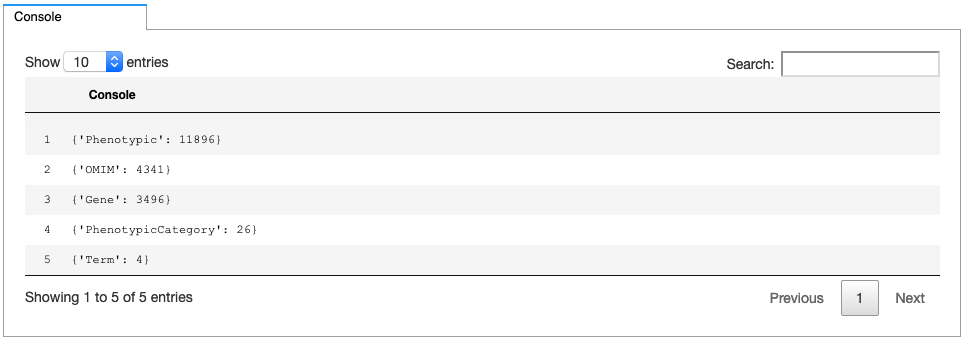

In [5]:
%%gremlin
g.V().groupCount().by(label).order(local).by(values, Order.decr).unfold()

### 按label分组统计边的数量
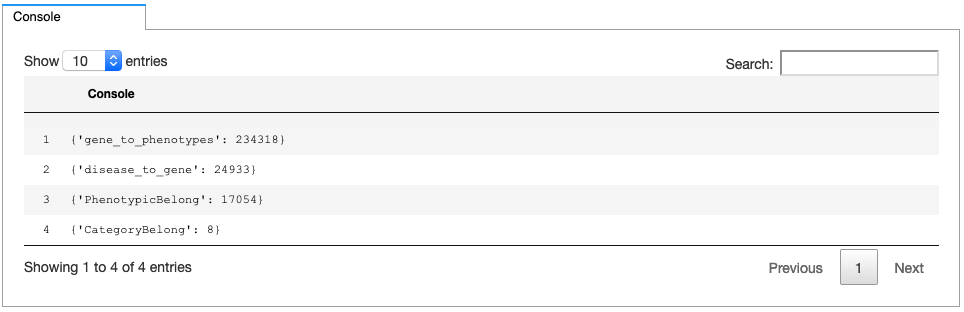

In [6]:
%%gremlin
g.E().groupCount().by(label).order(local).by(values, Order.decr).unfold()

到目前我们构建了从疾病到基因，再到表型及其分类的网络，从主体关联上虽然很简单，但实际的每个实体间的关系都是多对多的关系
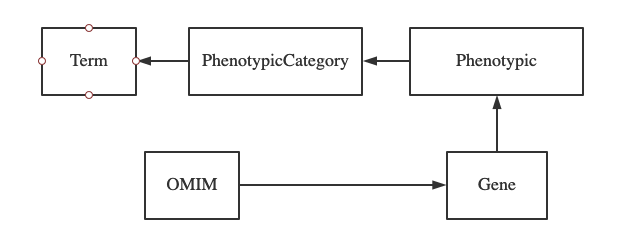



我们可以尝试查找从 **Gitelman综合征** —> Gene —> 表型 —> 表型分类路径
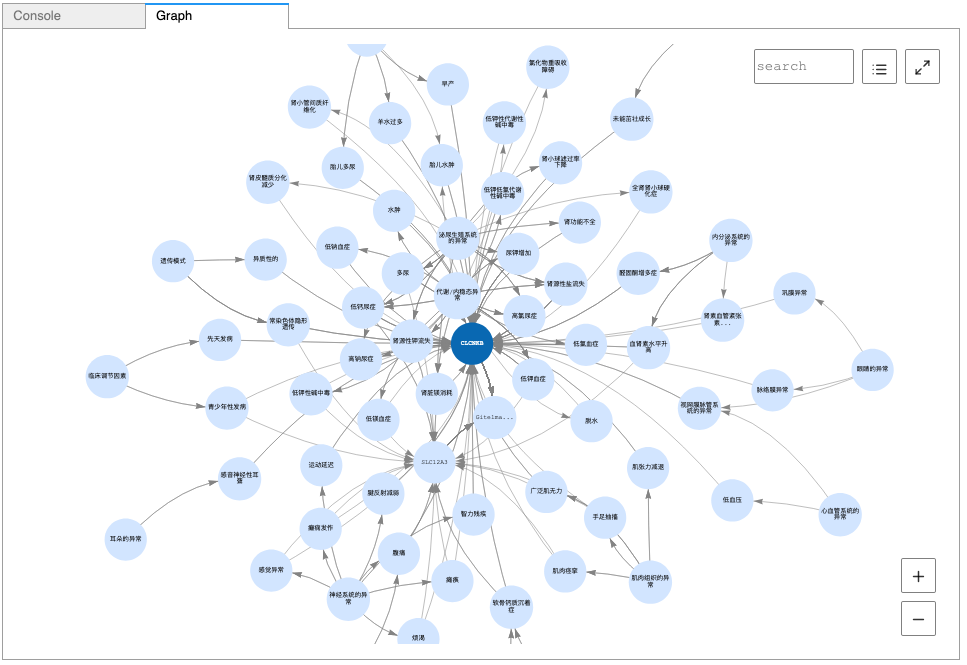

In [1]:
%%gremlin -p v,outv,outv,outv
g.V().hasLabel('OMIM').has('disease_name_cn','Gitelman综合征')
.out()
.out()
.out()
.simplepath()
.by('disease_name_cn')
.by(id)
.by('name_cn')
.by(id)
.limit(180)